In [1]:
import torch
import string
import pandas as pd
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset
from torch.autograd import Variable
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
RANDOM_SEED = 1

### Create Palindrome Dataset

In [2]:
def generate_random_string(length):
    return ''.join(np.random.choice(list('abcdefghijklmnopqrstuvwxyz'), length))


def generate_palindrome(length):
    half_length = length // 2
    half_string = generate_random_string(half_length)
    if length % 2 == 0:
        return half_string + half_string[::-1]
    else:
        return half_string + np.random.choice(list('abcdefghijklmnopqrstuvwxyz')) + half_string[::-1]
    

def generate_dataset(num_samples, string_lengths):
    data = []
    num_samples_per_length = num_samples // len(string_lengths)
    for length in string_lengths:
        for _ in range(num_samples_per_length):
            if np.random.rand() > 0.5:
                string = generate_random_string(length)
                label = 1
            else:
                string = generate_palindrome(length)
                label = 0
            data.append([string, label])
    return data


### Create Manual Palindrome Model

In [3]:
class CustomTokenizer:
    def __init__(self):
        # Define the special tokens
        self.tokens = list(string.ascii_lowercase)
        self.token_to_id = {token: i for i, token in enumerate(self.tokens)}
        self.id_to_token = {i: token for token, i in enumerate(self.tokens)}
        self.vocab = set(self.tokens)
        self.vocab_size = len(self.vocab)
        self.max_word_length = 200
    
    def to_matrix(self, word):
        rows = len(word)
        cols = len(self.vocab)
        matrix = torch.zeros((rows, cols), dtype=torch.float32)
        for i, char in enumerate(word):
            matrix[i, self.token_to_id[char]] = 1.0
        return matrix
    
class PalindromeNetwork(nn.Module):
    def __init__(self):
        super(PalindromeNetwork, self).__init__()
        self.tokenizer = CustomTokenizer() 
        self.IPrime = torch.flip(torch.eye(self.tokenizer.max_word_length), [0])
        

    def forward(self, x):
        word_len = len(x)
        P = self.tokenizer.to_matrix(x)
        d = torch.norm(P - self.IPrime[-1*word_len:, :word_len].matmul(P), p="fro")
        return d
    
net = PalindromeNetwork()

print("Output for 'aba': ", net("aba").item())
print("Output for 'abb': ", net("abb").item())
print("Output for 'cba': ", net("cba").item())
print("Output for 'racecar': ", net("racecar").item())
print("Output for 'saippuakivikauppias': ", net("saippuakivikauppias").item())


Output for 'aba':  0.0
Output for 'abb':  2.0
Output for 'cba':  2.0
Output for 'racecar':  0.0
Output for 'saippuakivikauppias':  0.0


### Learn Reverse Identity Matrix

In [6]:
class CustomTokenizer:
    def __init__(self):
        # Define the special tokens
        self.tokens = list(string.ascii_lowercase)
        self.token_to_id = {token: i for i, token in enumerate(self.tokens)}
        self.id_to_token = {i: token for token, i in enumerate(self.tokens)}
        self.vocab = set(self.tokens)
        self.vocab_size = len(self.vocab)
        self.max_word_length = 7
    
    def to_matrix(self, word):
        rows = len(word)
        cols = len(self.vocab)
        matrix = torch.zeros((rows, cols), dtype=torch.float32)
        for i, char in enumerate(word):
            matrix[i, self.token_to_id[char]] = 1.0
        return matrix
    
class PalindromeNetwork(nn.Module):
    def __init__(self):
        super(PalindromeNetwork, self).__init__()
        self.tokenizer = CustomTokenizer() 
        self.IPrime = nn.Parameter(torch.zeros(self.tokenizer.max_word_length,self.tokenizer.max_word_length))

    def forward(self, P):
        word_len = P.shape[0]
        d = torch.norm(P - self.IPrime[-1*word_len:, :word_len].matmul(P), p="fro")
        d = nn.functional.tanh(d)
        return d

dataset = generate_dataset(10000, [3,4,5])
tokenizer = CustomTokenizer()
X = []
for row in dataset:
    X.append([tokenizer.to_matrix(row[0]), row[1]])


# Training loop
model = PalindromeNetwork()
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)
num_epochs = 7
for epoch in range(num_epochs):
    total_loss = 0
    for data in X:
        inputs, label = data
        label = torch.tensor([label], dtype=torch.float32)
        
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(inputs)
        
        loss = criterion(outputs, label)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss/len(X):.4f}')


Epoch [1/7], Loss: 0.0261
Epoch [2/7], Loss: 0.0075
Epoch [3/7], Loss: 0.0074
Epoch [4/7], Loss: 0.0074
Epoch [5/7], Loss: 0.0074
Epoch [6/7], Loss: 0.0073
Epoch [7/7], Loss: 0.0073


[[ 0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.46 -0.    0.    0.    0.54  0.    0.  ]
 [ 0.15  0.08  0.    0.92 -0.15  0.    0.  ]
 [-0.03 -0.03  1.    0.03  0.03  0.    0.  ]
 [ 0.02  1.02 -0.   -0.02 -0.02  0.    0.  ]
 [ 1.08  0.06 -0.   -0.06 -0.08  0.    0.  ]]


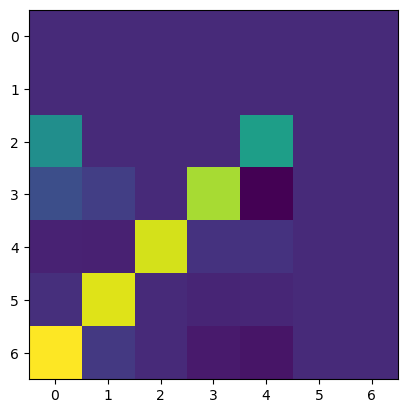

In [7]:
print(model.IPrime.detach().numpy().round(2))
plt.imshow(model.IPrime.detach().numpy())

In [16]:
print(model(tokenizer.to_matrix("abbba")))
print(model(tokenizer.to_matrix("abbbba")))

tensor(0.0002, grad_fn=<TanhBackward0>)
tensor(0.8384, grad_fn=<TanhBackward0>)
